In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease


In [3]:
import kagglehub
import os
import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models, optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

# --- 1. Dataset Download and Preparation ---
print("Downloading PlantVillage dataset...")

# Your specified dataset download using kagglehub
# NOTE: The name 'emmarex/plantdisease' is for a common version of PlantVillage.
# The user-specified name "The plant village" is descriptive, but 'emmarex/plantdisease'
# is a known Kaggle Hub identifier.
dataset_name = "emmarex/plantdisease"
path = kagglehub.dataset_download(dataset_name)

print("Path to dataset files:", path)

# The dataset downloaded by kagglehub is often a compressed archive or nested.
# You may need to adjust the directory paths based on the exact structure
# of the 'emmarex/plantdisease' download. The common structure has a top-level
# folder, e.g., 'PlantVillage'.

# Assuming a common structure where 'train' and 'valid' folders are available
# inside a main folder after download/unzip, you might need an extra step:
# For the 'emmarex/plantdisease' dataset, the path often points to the downloaded folder itself.

# Check the downloaded path structure and update these directories if necessary
base_dir = path # This should be the root folder containing the train/valid data

# --- 2. Data Preparation and Augmentation ---
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Create ImageDataGenerators for image loading and augmentation
# Rescale is essential for CNNs
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # Use a split if the data is not pre-split
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# For validation/testing, we only rescale (no augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from the directory
# NOTE: If your downloaded dataset already has 'train' and 'valid' folders at `base_dir`,
# use flow_from_directory on those specific folders.
train_dir = os.path.join(base_dir, 'PlantVillage/train') # Adjust this path as needed
val_dir = os.path.join(base_dir, 'PlantVillage/valid') # Adjust this path as needed

# In some PlantVillage datasets, train/valid might not exist, and you may use one
# directory with the `validation_split` in train_datagen.

try:
    # Attempt to load from train/valid folders
    train_generator = val_datagen.flow_from_directory(
        train_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )
except:
    # Fallback/Alternative: Load from a single directory using the split
    print("Using validation split from a single directory...")
    main_data_dir = os.path.join(base_dir, 'PlantVillage') # Adjust this path as needed

    train_generator = train_datagen.flow_from_directory(
        main_data_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training'
    )

    validation_generator = train_datagen.flow_from_directory(
        main_data_dir,
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation'
    )

# Get the number of classes for the final layer
num_classes = train_generator.num_classes
print(f"Number of classes detected: {num_classes}")

# --- 3. Model Architecture (MobileNetV2 Transfer Learning) ---

# Load the MobileNetV2 model pre-trained on ImageNet
base_model = MobileNetV2(
    input_shape=IMAGE_SIZE + (3,),
    include_top=False, # Exclude the final classification layer
    weights='imagenet'
)

# Freeze the base model layers (initial training step)
base_model.trainable = False

# Build the model on top of the base
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(), # Reduces feature map size
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax') # Output layer
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4. Model Training ---
EPOCHS = 10 # You'll likely need more, but start small for a test run

print("\nStarting Model Training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE
)

# --- 5. Optional: Fine-Tuning the Model ---
# This is a crucial step to get good performance, but can be skipped for a quick run.
# print("\nStarting Fine-Tuning...")
# base_model.trainable = True
# fine_tune_at = 100 # Unfreeze layers from this layer onwards

# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# model.compile(
#     optimizer=optimizers.Adam(learning_rate=1e-5), # Use a very small learning rate
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history_fine = model.fit(
#     train_generator,
#     epochs=EPOCHS + 5,
#     initial_epoch=history.epoch[-1],
#     validation_data=validation_generator
# )

# --- 6. Save the Model ---
model.save("plant_disease_mobilenetv2.h5")
print("\nModel saved as plant_disease_mobilenetv2.h5")

Using Colab cache for faster access to the 'plantdisease' dataset.
Path to dataset files: /kaggle/input/plantdisease
Using validation split from a single directory...
Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Number of classes detected: 15


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,775 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)


Starting Model Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1121s 2s/step - accuracy: 0.5508 - loss: 1.4356 - val_accuracy: 0.8254 - val_loss: 0.5293
Epoch 2/10
  1/516 ━━━━━━━━━━━━━━━━━━━━ 15:31 2s/step - accuracy: 0.6875 - loss: 0.9380

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


516/516 ━━━━━━━━━━━━━━━━━━━━ 223s 429ms/step - accuracy: 0.6875 - loss: 0.9380 - val_accuracy: 0.8198 - val_loss: 0.5413
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1160s 2s/step - accuracy: 0.7766 - loss: 0.6720 - val_accuracy: 0.8511 - val_loss: 0.4521
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 263s 508ms/step - accuracy: 0.8125 - loss: 0.5068 - val_accuracy: 0.8550 - val_loss: 0.4486
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1114s 2s/step - accuracy: 0.8091 - loss: 0.5698 - val_accuracy: 0.8643 - val_loss: 0.3968
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 220s 425ms/step - accuracy: 0.6875 - loss: 0.6716 - val_accuracy: 0.8625 - val_loss: 0.4018
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.8116 - loss: 0.5423 - val_accuracy: 0.8738 - val_loss: 0.3756
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 220s 425ms/step - accuracy: 0.9375 - loss: 0.2490 - val_accuracy: 0.8696 - val_loss: 0.3807
Epoch 9/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.8254 - loss: 0.5275 - val


Model saved as plant_disease_mobilenetv2.h5


In [4]:
import os
print("Model saved to the directory:", os.getcwd())

Model saved to the directory: /content


In [5]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Make sure this path points to where you found your file
MODEL_FILE_PATH = "plant_disease_mobilenetv2.h5"

# Load the entire model (architecture, weights, and optimizer state)
loaded_model = load_model(MODEL_FILE_PATH)

print("Model successfully loaded into memory!")

Model successfully loaded into memory!


In [6]:
# Display the model architecture and parameters
loaded_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,777 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Check if the file is in the current directory (Colab's /content/)
# If you don't see it, you may need to use the full path.
MODEL_FILE_PATH = "plant_disease_mobilenetv2.h5"

try:
    loaded_model = load_model(MODEL_FILE_PATH)
    print("✅ Model successfully loaded!")
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("Please check the Colab file browser to confirm the file name and path.")

# Check the model summary to confirm structure
loaded_model.summary()

✅ Model successfully loaded!


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,589,777 (9.88 MB)

 Trainable params: 331,791 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 2 (12.00 B)

In [8]:
# Assuming validation_generator is still defined and accessible in your Colab session

# 1. Access the dictionary where Keras stores the mapping (e.g., {'Apple___Black_rot': 0, 'Tomato___healthy': 1, ...})
class_indices = validation_generator.class_indices

# 2. Reverse the dictionary to map index (number) to name (string)
# This is crucial because the model outputs the index (e.g., '0'), not the name.
index_to_name = {v: k for k, v in class_indices.items()}

# 3. Create the final, ordered list of class names (starting at index 0)
num_classes = len(index_to_name)
class_names = [index_to_name[i] for i in range(num_classes)]

print("✅ Class names successfully extracted!")
print(f"The first three classes are: {class_names[0:3]}")
print(f"Total classes found: {len(class_names)}")

✅ Class names successfully extracted!
The first three classes are: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight']
Total classes found: 15


In [16]:
# --- Define the full remedy dictionary in memory ---
# This takes the place of loading the remedies.json file.
remedy_data = {
    "Pepper__bell___Bacterial_spot": "Remedy: Prune and destroy infected leaves. Use copper-based bactericides.",
    "Pepper__bell___healthy": "No remedy needed! Your plant is healthy and thriving.",
    "Potato___Early_blight": "Remedy: Apply fungicides containing chlorothalonil or mancozeb. Ensure proper watering.",
    "Potato___Late_blight": "Remedy: Immediately destroy all infected plant material. Apply systemic fungicides.",
    "Tomato___Bacterial_spot": "Remedy: Use disease-free seeds and seedlings. Apply fixed copper sprays.",
    "Tomato___Early_blight": "Remedy: Apply fungicides containing chlorothalonil. Avoid overhead watering.",
    "Tomato___Late_blight": "Remedy: Destroy infected plants immediately. Use broad-spectrum fungicides.",
    "Tomato___Leaf_Mold": "Remedy: Improve air circulation (pruning). Apply chlorothalonil or copper fungicides.",
    "Tomato___Septoria_leaf_spot": "Remedy: Remove and destroy lower infected leaves. Apply copper-based fungicides.",
    "Tomato___Spider_mites Two-spotted_mite": "Remedy: Spray with insecticidal soap or horticultural oil. Use a strong jet of water to dislodge mites.",
    "Tomato___Target_Spot": "Remedy: Apply fungicides like azoxystrobin. Practice crop rotation.",
    "Tomato___Tomato_mosaic_virus": "Remedy: Remove and destroy infected plants immediately. Sanitize tools and hands frequently.",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus": "Remedy: Control whiteflies with insecticides or reflective mulches. Remove infected plants.",
    "Tomato___healthy": "No remedy needed! Your plant is healthy and thriving.",
    "Tomato___Blight": "Remedy: Apply broad-spectrum fungicides. Ensure proper soil drainage and avoid wetting foliage."
}

print("✅ Remedy data dictionary created in memory (remedy_data).")

✅ Remedy data dictionary created in memory (remedy_data).


✅ Model successfully loaded.
✅ Remedy data and class names should be loaded from previous cells.

--- Image Upload ---


Saving 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132.JPG to 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132 (1).JPG
Uploaded file: 00f2e69a-1e56-412d-8a79-fdce794a17e4___JR_B.Spot 3132 (1).JPG
Running prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


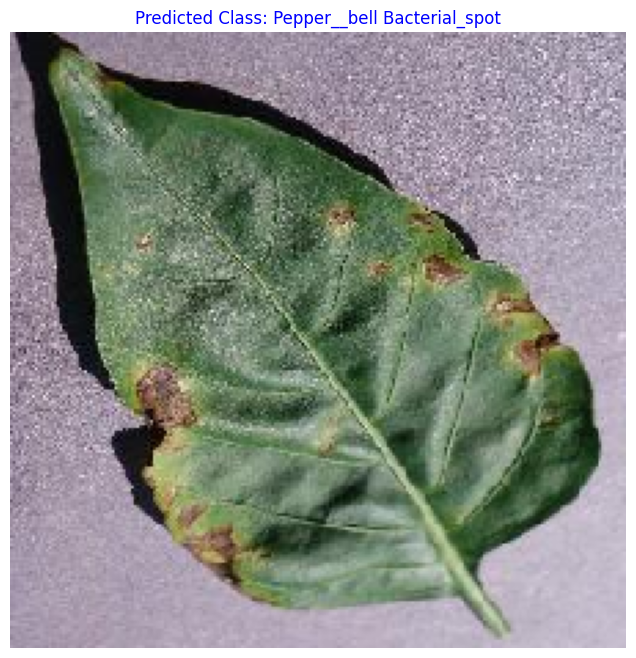


--- DIAGNOSIS RESULT ---
Prediction: Pepper__bell Bacterial_spot
Confidence: 97.15%
------------------------------
STATUS: ⚠️ DISEASE DETECTED

💊 ACTIONABLE REMEDY / ADVICE:
Remedy: Prune and destroy infected leaves. Use copper-based bactericides.

Processing complete.


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from google.colab import files
import io
import json
from tensorflow.keras.models import load_model

# --- LOAD NECESSARY DATA ---
# This assumes the 'remedy_data' dictionary and 'class_names' list
# are defined in a previous Colab cell.
MODEL_FILE_PATH = "plant_disease_mobilenetv2.h5"
# Ensure the model file is accessible in the Colab environment
loaded_model = load_model(MODEL_FILE_PATH)
print("✅ Model successfully loaded.")
print("✅ Remedy data and class names should be loaded from previous cells.")


# --- 1. UPLOAD THE IMAGE ---
print("\n--- Image Upload ---")
# Use the Colab files widget to upload an image
uploaded = files.upload()

if not uploaded:
    print("No file uploaded. Exiting.")
    # You might want to remove 'exit()' in Streamlit apps for continuous running
    # but it's fine here for a one-off test.

# Get the filename of the uploaded image
image_filename = next(iter(uploaded))
print(f"Uploaded file: {image_filename}")


# --- 2. PREPROCESS & PREDICT ---
IMAGE_SIZE = (224, 224)

# Load the image from the uploaded bytes
img = image.load_img(io.BytesIO(uploaded[image_filename]), target_size=IMAGE_SIZE)

# Convert to array, add batch dimension, and normalize
img_array = np.expand_dims(image.img_to_array(img), axis=0)
img_array /= 255.0

print("Running prediction...")
predictions = loaded_model.predict(img_array)
predicted_index = np.argmax(predictions[0])
confidence = predictions[0][predicted_index] * 100
predicted_name = class_names[predicted_index]


# --- 3. DISPLAY RESULTS & LOOKUP REMEDY ---
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f"Predicted Class: {predicted_name.replace('___', ' ')}", color='blue')
plt.axis('off')
plt.show()

print("\n--- DIAGNOSIS RESULT ---")
print(f"Prediction: {predicted_name.replace('___', ' ')}")
print(f"Confidence: {confidence:.2f}%")
print("-" * 30)

if 'healthy' in predicted_name.lower():
    print("STATUS: ✅ HEALTHY")

    # --- REMEDY/ADVICE FOR HEALTHY ---
    # The remedy_data.get() will pull the "No remedy needed" message
    remedy = remedy_data.get(predicted_name, "Advice not available.")
    print("\n🌿 GENERAL ADVICE:")
    print(remedy)

else:
    print("STATUS: ⚠️ DISEASE DETECTED")

    # --- REMEDY LOOKUP FOR DISEASED ---
    # This is the line you asked for! It pulls the specific advice.
    remedy = remedy_data.get(
        predicted_name,
        "Remedy not available in the database. Please research further."
    )

    print("\n💊 ACTIONABLE REMEDY / ADVICE:")
    print(remedy)

print("\nProcessing complete.")